check here

[https://github.com/anujshah1003/own_data_cnn_implementation_keras/blob/master/custom_data_cnn.py]

[https://www.youtube.com/watch?v=NUuMg5m42-g]

In [197]:
%matplotlib inline
from helpers import *

# import 'Sequential' is a linear stack of neural network layers. Will be used to build the feed-forward CNN
from keras.models import Sequential 
# import the "core" layers from Keras (these are the most common layers)
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
# import the convolutional layers that will help us efficiently train on image data
from keras.layers import Conv2D, MaxPooling2D
# these utilities will help us transform our data
from keras.utils import np_utils
from keras import backend as K

from sklearn.metrics import classification_report,confusion_matrix
import itertools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth, after discretizing by "discretizing" it patch-wise.

### - Load data

In [98]:
# Loaded a set of images
n = 2

imgs, gt_imgs = load_images(n)

imgs[0].shape, gt_imgs[0].shape

Loading 2 images


((400, 400, 3), (400, 400))

### - For now avoid cross validation, just split the datasest in test and train. 

In [99]:
train_ratio = 0.5
train, test = split_train_test(imgs, gt_imgs, train_ratio=train_ratio, seed=1)
train.imgs.shape, train.gt_imgs.shape, test.imgs.shape, test.gt_imgs.shape 

((1, 400, 400, 3), (1, 400, 400), (1, 400, 400, 3), (1, 400, 400))

### - Generate the inpus and the outputs
We reshape each input to fulfill the requirements of the tensorflow library. 

In [100]:
def gt_imgs_to_Y(gt_imgs, patch_width=8):
    if len(gt_imgs>0):
        gt_matr = np.array([img_crop_matr(gt_img, patch_width) for gt_img in gt_imgs])
        Y = np.zeros((gt_matr.shape[0], gt_matr.shape[1], gt_matr.shape[2])) # keep width and heigth but convert the patch to a class
        for im in range(Y.shape[0]):
            for i in range(Y.shape[1]):
                for j in range(Y.shape[2]):
                    Y[im, i, j] = value_to_class(np.mean(gt_matr[im, i, j]))
        return np_utils.to_categorical(Y, 2)
#         return Y
    return np.array(None)
    
train.X = train.imgs
train.Y = gt_imgs_to_Y(train.gt_imgs, 8)

test.X = test.imgs
test.Y = gt_imgs_to_Y(test.gt_imgs, 8)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape

((1, 400, 400, 3), (1, 50, 50, 2), (1, 400, 400, 3), (1, 50, 50, 2))

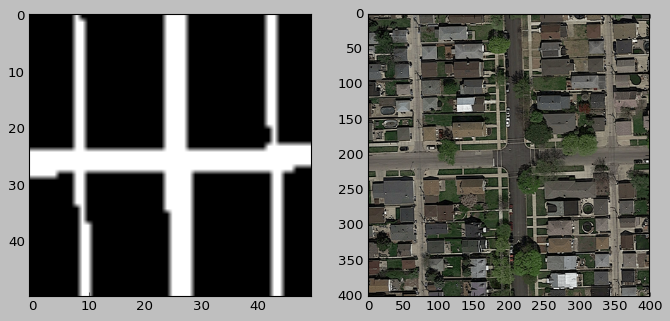

In [101]:
# check it makes sense
i = 0
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# fig.set_figure(figsize=(20,10))
axs[0].imshow(train.Y[i, :, :, 1], cmap='gray')
axs[1].imshow(train.X[i, :, :])

Recap on **train** (and test) object:
- **train.imgs**: images of the training set. **shape**=(#train images, 400, 400, 3)
- **train.gt_imgs**: respective groundtruth images. **shape**=(#train images, 400, 400)
- **train.X**: = **train.imgs**. **shape**=(#train images, 400, 400, 3)
- **train.Y**: outputs extracted from train.gt_imgs. **shape**=(#train images, 50, 50, 2)

### - Build the CNN model

In [245]:
# wiht leaky relu
nclasses = 2
model = Sequential()

# padding="same" => output width/heigth = input width/heigth

# layer 1
model.add(
    Conv2D(32, (11, 11), 
           padding="same", 
           input_shape=train.X[0].shape)) # variable size input?
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25)) 

# layer 2
model.add(
    Conv2D(48, (5, 5),
           strides=(2, 2),
           padding="same"
          ))
model.add(LeakyReLU(alpha=0.1))

# # later 3
# model.add(
#     Conv2D(48, (5, 5), 
#            padding="same")) 
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(0.25)) 

# layer 4
model.add(
    Conv2D(48, (5, 5),
           strides=(2, 2),
           padding="same"))
model.add(LeakyReLU(alpha=0.1))

# # layer 5
# model.add(
#     Conv2D(48, (5, 5), 
#            padding="same")) 
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(0.25)) 

# layer 6
model.add(
    Conv2D(64, (5, 5), 
           strides=(2, 2),
           padding="same"))
model.add(LeakyReLU(alpha=0.1))

# # layer 7
# model.add(
#     Conv2D(64, (5, 5), 
#            padding="same")) 
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(0.25)) 

# layer 8
model.add(
    Conv2D(2, (5, 5), 
           padding="same"))
model.add(LeakyReLU(alpha=0.1))

model.add(Activation('softmax'))

train.X[0].shape, model.output_shape

((400, 400, 3), (None, 50, 50, 2))

In [236]:
# with relu
nclasses = 2
model = Sequential()

# padding="same" => output width/heigth = input width/heigth

# layer 1
model.add(
    Conv2D(32, (11, 11), 
           activation='relu',
           padding="same", 
           input_shape=train.X[0].shape)) # variable size input?
model.add(Dropout(0.25)) 

# layer 2
model.add(
    Conv2D(48, (5, 5),
           activation='relu',
           strides=(2, 2),
           padding="same"
          ))

# later 3
model.add(
    Conv2D(48, (5, 5), 
           activation='relu',
           padding="same")) 
model.add(Dropout(0.25)) 

# layer 4
model.add(
    Conv2D(48, (5, 5),
           activation='relu',
           strides=(2, 2),
           padding="same"))

# layer 5
model.add(
    Conv2D(48, (5, 5), 
           activation='relu',
           padding="same")) 
model.add(Dropout(0.25)) 

# layer 6
model.add(
    Conv2D(64, (5, 5), 
           activation='relu',
           strides=(2, 2),
           padding="same"))

# layer 7
model.add(
    Conv2D(64, (5, 5), 
           activation='relu',
           padding="same")) 
model.add(Dropout(0.25)) 

# layer 8
model.add(
    Conv2D(2, (5, 5), 
           activation='relu',
           padding="same"))

model.add(Activation('softmax'))

train.X[0].shape, model.output_shape

((400, 400, 3), (None, 50, 50, 2))

In [294]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 400, 400, 32)      11648     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 400, 400, 32)      0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 400, 400, 32)      0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 200, 200, 48)      38448     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 200, 200, 48)      0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 100, 100, 48)      57648     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 100, 100, 48)      0         
__________

In [247]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### - Fit the model on the train data

In [226]:
train.X.shape, train.Y.shape

((1, 400, 400, 3), (1, 50, 50, 2))

In [275]:
# either validation_data=(test.X, test.Y) or validation_split=0.2
num_epoch = 200
hist=model.fit(train.X, train.Y, batch_size=32, epochs=num_epoch, verbose=1, validation_data=(test.X, test.Y))

Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.4728 - acc: 0.7856 - val_loss: 0.5505 - val_acc: 0.7232
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.4827 - acc: 0.7692 - val_loss: 0.5116 - val_acc: 0.7584
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.4538 - acc: 0.8044 - val_loss: 0.4903 - val_acc: 0.7684
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.4333 - acc: 0.8088 - val_loss: 0.4989 - val_acc: 0.7572
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 0.4400 - acc: 0.8008 - val_loss: 0.5346 - val_acc: 0.7512
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.5079 - acc: 0.7656 - val_loss: 0.5351 - val_acc: 0.7536
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 0.4518 - acc: 0.7944 - val_loss: 0.5168 - val_acc: 0.7672
Epoch 8/100
1/1 [==============================] - 3s 3s/step 

Epoch 65/100
1/1 [==============================] - 3s 3s/step - loss: 0.1050 - acc: 0.9592 - val_loss: 0.7010 - val_acc: 0.8104
Epoch 66/100
1/1 [==============================] - 3s 3s/step - loss: 0.0856 - acc: 0.9736 - val_loss: 0.7402 - val_acc: 0.7856
Epoch 67/100
1/1 [==============================] - 3s 3s/step - loss: 0.1067 - acc: 0.9592 - val_loss: 0.8294 - val_acc: 0.7904
Epoch 68/100
1/1 [==============================] - 3s 3s/step - loss: 0.1112 - acc: 0.9592 - val_loss: 0.6705 - val_acc: 0.8236
Epoch 69/100
1/1 [==============================] - 3s 3s/step - loss: 0.1061 - acc: 0.9508 - val_loss: 0.6542 - val_acc: 0.8236
Epoch 70/100
1/1 [==============================] - 3s 3s/step - loss: 0.0850 - acc: 0.9672 - val_loss: 0.6842 - val_acc: 0.8100
Epoch 71/100
1/1 [==============================] - 3s 3s/step - loss: 0.0885 - acc: 0.9676 - val_loss: 0.6400 - val_acc: 0.7960
Epoch 72/100
1/1 [==============================] - 3s 3s/step - loss: 0.0658 - acc: 0.9816 - val

#### Plot the accuracy and the loss obtained during training

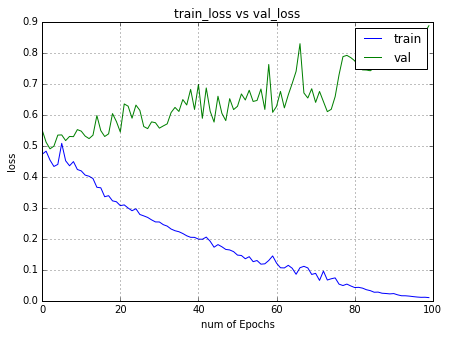

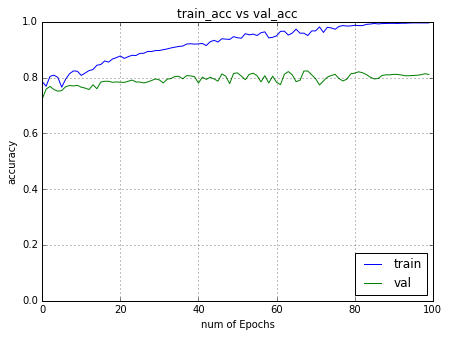

In [276]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

#### Display the output of a specific layer

In [287]:
# choose a layer and an image 
test_image = test.X[0:1]
layer_num=8

# these are all the layers, 
model.layers

feature_maps (output of layer 8): (50, 50, 64)


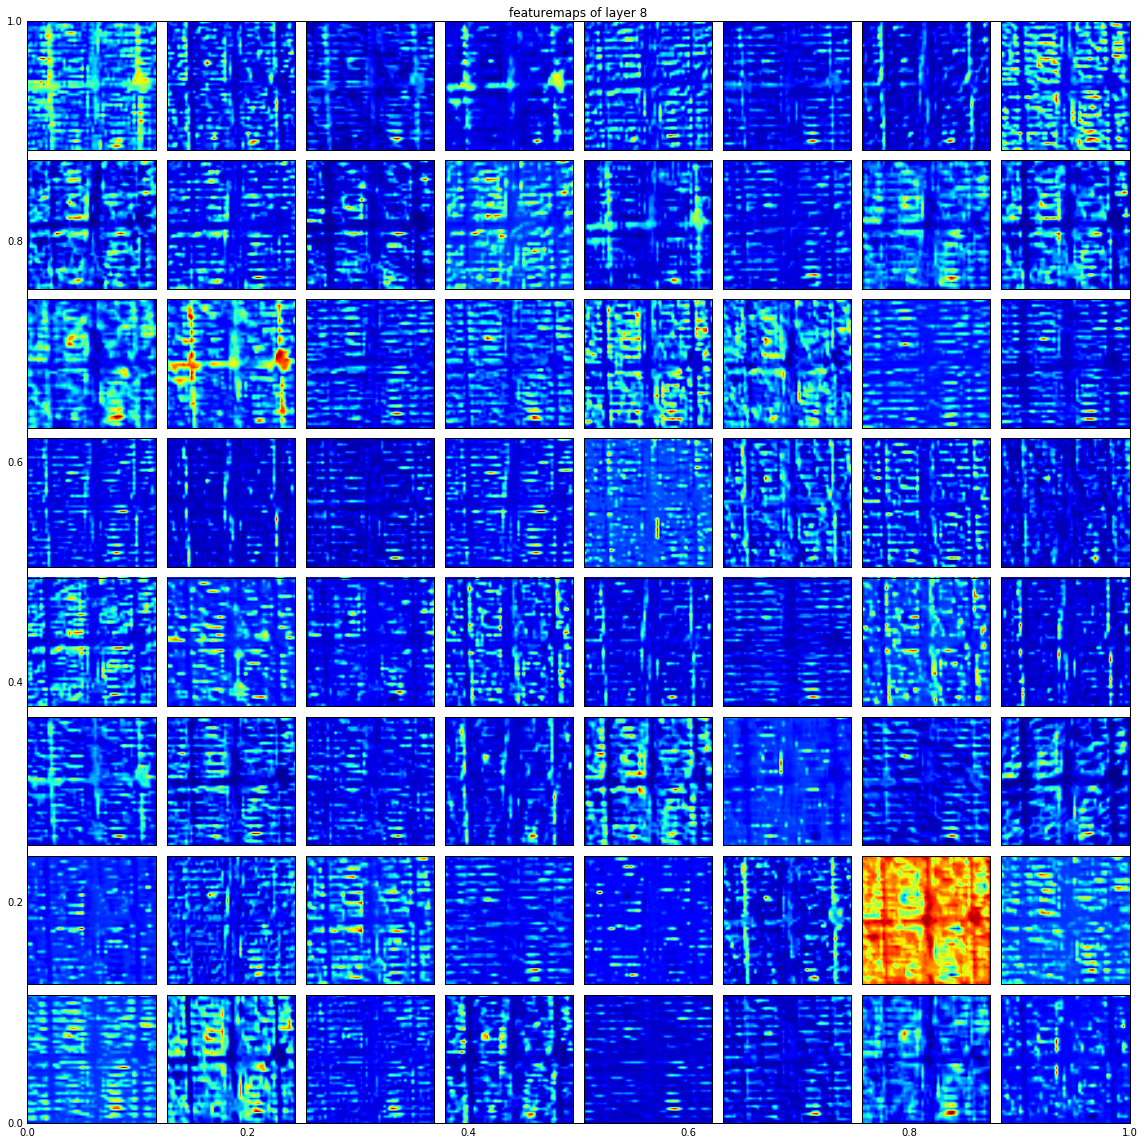

In [288]:
# Visualizing the intermediate layer
def get_featuremaps(model, layer_idx, X_batch):
#     visualize layer n layer_idx
    get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

activations = get_featuremaps(model, int(layer_num), test_image)
# print(np.shape(activations))

feature_maps = activations[0][0]      
if K.image_dim_ordering()=='th':
    feature_maps=np.rollaxis((np.rollaxis(feature_maps,2,0)),2,0)
print("feature_maps (output of layer " + str(layer_num) + "):", feature_maps.shape)

# show just one filter relative to the layer
# fig=plt.figure(figsize=(16,16))
# filter_num=0
# plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
# plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.jpg')

# show all the filters
num_of_featuremaps=feature_maps.shape[2]
fig=plt.figure(figsize=(16,16))
plt.title("featuremaps of layer {}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    ax.imshow(feature_maps[:,:,i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
# fig.savefig("featuremaps-layer-{}".format(layer_num) + '.jpg')
# you should be able to see that the cnn is keeping less information while the image goes through (keep only the
# important features)

### - Evaluate the model on the test data

                precision    recall  f1-score   support

0 (background)       0.90      0.84      0.87      1851
      1 (road)       0.62      0.72      0.66       649

   avg / total       0.82      0.81      0.82      2500

Confusion matrix, without normalization
Normalized confusion matrix


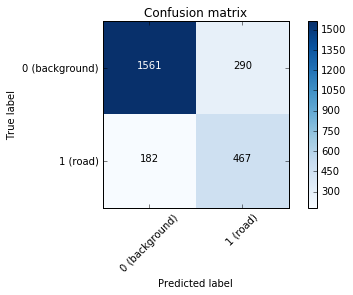

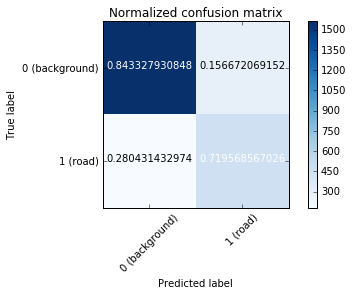

In [291]:
# check the performance on train or test
set_ = test

pred = model.predict_classes(set_.X).flatten()
true = np.argmax(set_.Y, axis=3).flatten()

# print(y_pred)
target_names = ['0 (background)', '1 (road)']

# print precision, recall, F1 score
print(classification_report(true, pred, target_names=target_names))


# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = (confusion_matrix(true, pred))

np.set_printoptions(precision=2)

plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
plt.figure()
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                     title='Normalized confusion matrix')
#plt.figure()
plt.show()

### - Show a prediction

((400, 400, 3), (50, 50))

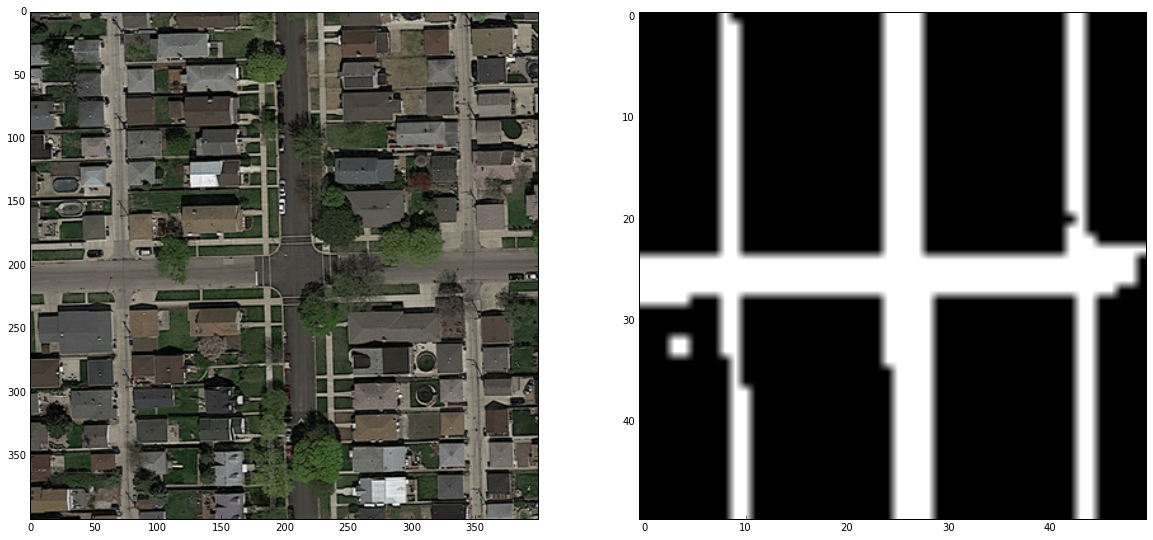

In [293]:
# choose an image to predict
img = train.X[0]

pred = model.predict_classes(np.array([img]))[0]

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((20, 10))

axs[0].imshow(img)
axs[1].imshow(pred, cmap='gray')
img.shape, pred.shape

**problem**: it predicts always the same class [check here](https://stackoverflow.com/questions/41488279/neural-network-always-predicts-the-same-class)

### - Save/load model

In [ ]:
# # Saving and loading model and weights
# from keras.models import model_from_json
# from keras.models import load_model

# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

# model.save('model.hdf5')
# loaded_model=load_model('model.hdf5')